In [1]:
import pandas as pd
from scipy.interpolate import interp1d
import numpy as np
import mne
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt, hilbert, detrend


# Utils

In [2]:
def find_nearest(array, value, return_index=False):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return (array[idx], idx) if return_index else array[idx]

In [3]:
def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def extract_band_power(eeg_df, eeg_cols, fs, band_name, lowcut, highcut):
    power_df = pd.DataFrame()
    power_df['time'] = eeg_df['time']
    for col in eeg_cols:
        signal = eeg_df[col].values
        filtered = bandpass_filter(signal, fs, lowcut, highcut)
        power = np.abs(hilbert(filtered)) ** 2
        power_df[f'{col}_{band_name}_power'] = power
    return power_df

# Importing data

In [11]:
data_dirs = '/Users/danielgarcia-barnett/Desktop/Coding/cpCST_data_analysis/data/cpCST_EEG_data'
behavior_data_dirs = '/Users/danielgarcia-barnett/Desktop/Coding/cpCST_data_analysis/data/proc_cpCST_data'
update_irt_data_dirs = '/Users/danielgarcia-barnett/Desktop/Coding/cpCST_data_analysis/IRT_extraction/proc_IRT_data/reproc_irt_data'
irt_data_dirs = '/Users/danielgarcia-barnett/Desktop/Coding/cpCST_data_analysis/IRT_extraction/proc_IRT_data'

In [12]:
cpCST_eeg_files = []
for dirs, fldrs, files in os.walk(data_dirs):
    cpCST_file = [file for file in files if 'run-02_eeg.edf' in file]
    if len(cpCST_file) > 0:
        cpCST_eeg_files.append(cpCST_file[0])

ptp_list = [file.split('_')[0].split('-')[-1] for file in cpCST_eeg_files]

available_ptps = [file.split('_')[0].split('-')[-1] for file in os.listdir(behavior_data_dirs) if any(ptp for ptp in ptp_list if ptp in file) and file.endswith('.csv')]

ptp = available_ptps[0]

In [14]:
for file in os.listdir(irt_data_dirs):
    if ptp in file:
        print(file)

In [8]:
ptp

'M10964385'

In [4]:
ptp_data_dirs = os.path.join(data_dirs, ptp)
eeg_fname = os.path.join(ptp_data_dirs, [file for file in os.listdir(ptp_data_dirs) if file.endswith('.edf') and 'run-02' in file][0])
annot_fname = os.path.join(ptp_data_dirs, [file for file in os.listdir(ptp_data_dirs) if 'run-02' in file and 'events' in file and file.endswith('.tsv')][0])
behavior_fname = os.path.join(behavior_data_dirs, [file for file in os.listdir(behavior_data_dirs) if file.endswith('.csv') and ptp in file][0])

In [5]:
eeg_obj = mne.io.read_raw(eeg_fname)
eeg_df = eeg_obj.to_data_frame()
annot_df = pd.read_csv(annot_fname)
behavior_df = pd.read_csv(behavior_fname)
behavior_df['time'] = behavior_df['flip_time']

Extracting EDF parameters from /Users/danielgarcia-barnett/Desktop/Coding/cpCST_data_analysis/data/cpCST_EEG_data/M10964385/sub-M10964385_ses-MOBI1A_task-cst_run-02_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [8]:
def bandpass_filter(data, low_hz, high_hz, fs, order=4):
    b, a = butter(order, [low_hz, high_hz], btype='band', fs=fs)
    return filtfilt(b, a, np.asarray(data, dtype=float))

def extract_envelope(data, fs, band_range):
    # 1. Bandpass
    filtered = bandpass_filter(data, band_range[0], band_range[1], fs)
    # 2. Hilbert transform (analytic signal)
    analytic = hilbert(filtered)
    envelope = np.abs(analytic)
    # 3. Detrend envelope
    detrended = detrend(envelope, type='linear')
    return detrended

def estimate_fs(time, mad_thresh=4.0):
    t = np.asarray(time, dtype=float)
    t = t[np.isfinite(t)]
    dt = np.diff(t)
    dt = dt[dt > 0]
    m = np.median(dt)
    mad = np.median(np.abs(dt - m))
    if mad == 0:
        dt_clean = dt
    else:
        thr = mad_thresh * 1.4826 * mad
        dt_clean = dt[np.abs(dt - m) <= thr]
        if dt_clean.size == 0:
            dt_clean = dt
    fs = 1.0 / np.median(dt_clean)
    jitter_pct = 100.0 * np.std(dt_clean) / np.mean(dt_clean)
    return fs, jitter_pct, dt_clean

# Band extraction and Detrending

In [20]:
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

eeg_cols = [col for col in eeg_df.columns if 'time' not in col]
fs_est, jitter_pct, dt_clean = estimate_fs(eeg_df['time'])

all_columns = {'time': eeg_df['time'].values}

for col in eeg_cols:
    for band, band_range in bands.items():
        try:
            detrended_env = extract_envelope(eeg_df[col].values, fs_est, band_range)
            all_columns[f'{col}_{band}'] = detrended_env
            all_columns[f'{col}'] = eeg_df[col].values
        except Exception as e:
            print(f"Error on {col} {band}: {e}")

processed = pd.DataFrame(all_columns)

In [21]:
eeg_df['time_sec'] = eeg_df['time']
behavior_df['time_sec'] = behavior_df['time']
_, eeg_start_ind = find_nearest(eeg_df['time'], behavior_df.loc[0, 'time'], return_index=True)
eeg_df = eeg_df.loc[eeg_start_ind:]

interp_data = {'time': behavior_df['time'].values}
for col in processed.columns:
    if col != 'time':
        interp_data[col] = np.interp(behavior_df['time'], processed['time'], processed[col])

interp_df = pd.DataFrame(interp_data)
merged_df = pd.concat([behavior_df.reset_index(drop=True), interp_df.drop(columns='time')], axis=1)

In [16]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re
import math

# Identify bands/features
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
features = [col for col in merged_df.columns if any(b in col for b in bands)]

# Group columns by band
band_groups = {band: [col for col in features if f'_{band}_' in col] for band in bands}

# Determine layout
n_rows = max(len(cols) for cols in band_groups.values())
n_cols = len(bands)

# Create PDF
with PdfPages('/Users/danielgarcia-barnett/Desktop/eeg_features.pdf') as pdf:
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 2.5*n_rows), squeeze=False)

    for col_idx, band in enumerate(bands):
        cols = band_groups[band]
        for row_idx in range(n_rows):
            ax = axes[row_idx, col_idx]
            if row_idx < len(cols):
                ax.plot(merged_df[cols[row_idx]].values)
                ax.set_title(cols[row_idx], fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()

# Prediction

In [43]:
cpcst_cols = [col for col in behavior_df.columns if 'time' not in col]
eeg_cols = [col for col in eeg_df.columns if 'time' not in col]
eeg_cols = {col:[f'{col}_{band}' for band in bands] for col in eeg_cols}

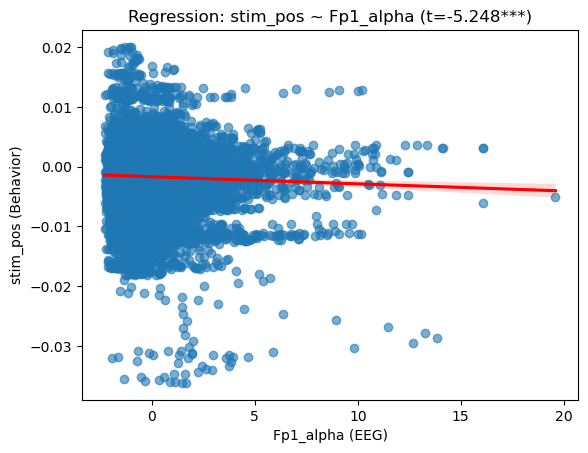

In [50]:
cpcst_feature = 'stim_pos'
eeg_feature = 'Fp1_alpha'
model = smf.ols(f'{cpcst_feature} ~ {eeg_feature}', data=merged_df).fit()
t, p = np.round(model.tvalues.iloc[1], 3), model.pvalues.iloc[1]
t_val = (f'{t}***' if p < 0.001 else 
        f'{t}**' if p < 0.01 else 
        f'{t}*' if p < 0.05 else 
        f'{t}')

sns.regplot(x=eeg_feature, y=cpcst_feature, data=merged_df, ci=95, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title(f'Regression: {cpcst_feature} ~ {eeg_feature} (t={t_val})')
plt.xlabel(f'{eeg_feature} (EEG)')
plt.ylabel(f'{cpcst_feature} (Behavior)')
plt.show()

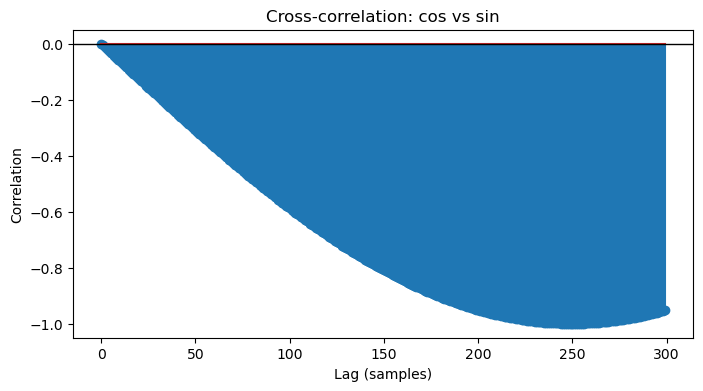

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf

# time base
fs = 1000
t = np.linspace(0, 2*np.pi, fs)

# signals
cos_sig = np.cos(t)
sin_sig = np.sin(t)

# demean
cos_sig -= cos_sig.mean()
sin_sig -= sin_sig.mean()

# compute cross-correlation
lags = 300
ccor = ccf(cos_sig, sin_sig)[:lags]

plt.figure(figsize=(8,4))
plt.stem(range(lags), ccor)
plt.axhline(0, color='k', linewidth=1)
plt.title('Cross-correlation: cos vs sin')
plt.xlabel('Lag (samples)')
plt.ylabel('Correlation')
plt.show()

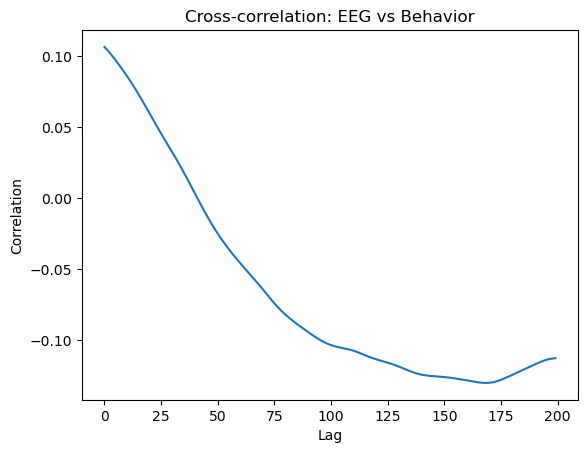

In [52]:
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt

eeg_series = merged_df['Fp1'] - merged_df['Fp1'].mean()
beh_series = merged_df['stim_pos'] - merged_df['stim_pos'].mean()

ccor = ccf(eeg_series, beh_series)[:200]  # first 200 lags
plt.plot(ccor)
plt.title('Cross-correlation: EEG vs Behavior')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

{'Fp1': ['Fp1_delta', 'Fp1_theta', 'Fp1_alpha', 'Fp1_beta', 'Fp1_gamma'],
 'Fz': ['Fz_delta', 'Fz_theta', 'Fz_alpha', 'Fz_beta', 'Fz_gamma'],
 'F3': ['F3_delta', 'F3_theta', 'F3_alpha', 'F3_beta', 'F3_gamma'],
 'F7': ['F7_delta', 'F7_theta', 'F7_alpha', 'F7_beta', 'F7_gamma'],
 'F9': ['F9_delta', 'F9_theta', 'F9_alpha', 'F9_beta', 'F9_gamma'],
 'FC5': ['FC5_delta', 'FC5_theta', 'FC5_alpha', 'FC5_beta', 'FC5_gamma'],
 'FC1': ['FC1_delta', 'FC1_theta', 'FC1_alpha', 'FC1_beta', 'FC1_gamma'],
 'C3': ['C3_delta', 'C3_theta', 'C3_alpha', 'C3_beta', 'C3_gamma'],
 'T7': ['T7_delta', 'T7_theta', 'T7_alpha', 'T7_beta', 'T7_gamma'],
 'CP5': ['CP5_delta', 'CP5_theta', 'CP5_alpha', 'CP5_beta', 'CP5_gamma'],
 'CP1': ['CP1_delta', 'CP1_theta', 'CP1_alpha', 'CP1_beta', 'CP1_gamma'],
 'Pz': ['Pz_delta', 'Pz_theta', 'Pz_alpha', 'Pz_beta', 'Pz_gamma'],
 'P3': ['P3_delta', 'P3_theta', 'P3_alpha', 'P3_beta', 'P3_gamma'],
 'P7': ['P7_delta', 'P7_theta', 'P7_alpha', 'P7_beta', 'P7_gamma'],
 'P9': ['P9_delta'

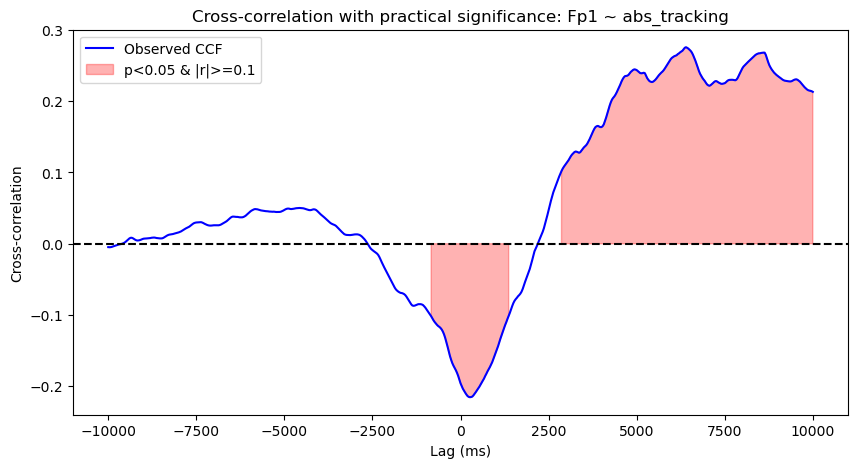

KeyboardInterrupt: 

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def block_permute(y, block_size=100, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    n = len(y)
    blocks = [y[i:i+block_size] for i in range(0, n, block_size)]
    rng.shuffle(blocks)
    return np.concatenate(blocks)[:n]

def xcorr(x, y, max_lag):
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)
    n = len(x)
    corr = np.correlate(x, y, mode='full') / n
    mid = len(corr) // 2
    lags = np.arange(-max_lag, max_lag+1)
    return lags, corr[mid-max_lag:mid+max_lag+1]

def permutation_xcorr(x, y, max_lag=200, n_perm=1000, block_size=100, seed=42):
    rng = np.random.default_rng(seed)
    lags, obs_corr = xcorr(x, y, max_lag)
    
    null_dist = np.zeros((n_perm, len(obs_corr)))
    for i in range(n_perm):
        y_perm = block_permute(y, block_size, rng)
        _, perm_corr = xcorr(x, y_perm, max_lag)
        null_dist[i, :] = perm_corr
    
    # Two-sided p-values
    pvals = np.mean(np.abs(null_dist) >= np.abs(obs_corr), axis=0)
    return lags, obs_corr, pvals

def plot_ccf_practical(x, y, fs, max_lag=200, n_perm=1000, block_size=100, feature_name="EEG vs Behavior", min_r=0.1):
    lags, obs_corr, pvals = permutation_xcorr(x, y, max_lag, n_perm, block_size)
    
    # Convert lags to ms
    lag_times = lags / fs * 1000  # ms
    
    plt.figure(figsize=(10,5))
    plt.plot(lag_times, obs_corr, label="Observed CCF", color="blue")
    plt.axhline(0, color="black", linestyle="--")
    
    # Significant AND practically meaningful
    sig_mask = (pvals < 0.05) & (np.abs(obs_corr) >= min_r)
    plt.fill_between(lag_times, obs_corr, 0, where=sig_mask, 
                     color="red", alpha=0.3, label=f"p<0.05 & |r|>={min_r}")
    
    plt.xlabel("Lag (ms)")
    plt.ylabel("Cross-correlation")
    plt.title(f"Cross-correlation with practical significance: {feature_name}")
    plt.legend()
    plt.show()
    
    return lags, obs_corr, pvals

# Example usage
fs = 30  # EEG/behavior sampling rate in Hz
for eeg, band_list in eeg_cols.items():
    for band in [eeg]+band_list:
        x = merged_df[band].values
        y = merged_df['abs_tracking'].values

        lags, obs_corr, pvals = plot_ccf_practical(
            x, y, fs, max_lag=300, n_perm=500, block_size=100,
            feature_name=f"{band} ~ abs_tracking", min_r=0.1)

## Feature Extraction: Power

In [111]:
n_samples = 1000
fs = n_samples/(merged_df.loc[n_samples, 'time'] - merged_df.loc[0, 'time'])

def bandpower(data, fs, band, window_sec=2):
    band = np.asarray(band)
    freqs, psd = welch(data, fs, nperseg=window_sec*fs)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= band[0], freqs <= band[1])
    return np.trapezoid(psd[idx_band], dx=freq_res)

bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45)
}

channel = merged_df['Fp1'].values

band_powers = {band: bandpower(channel, fs, rng) for band, rng in bands.items()}
print(band_powers)

{'delta': np.float64(60.20872117885881), 'theta': np.float64(3.131567174613887), 'alpha': np.float64(1.578856722332567), 'beta': np.float64(0.5062047887494293), 'gamma': np.float64(0.0)}


In [100]:
def bandpass_filter(data, low, high, fs, order=4):
    nyq = 0.5 * fs
    low /= nyq
    high /= nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

alpha_signal = bandpass_filter(channel, 8, 13, fs)

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt



def bandpass_filter(data, low_hz, high_hz, fs, order=4):
    b, a = butter(order, [low_hz, high_hz], btype='band', fs=fs)
    return filtfilt(b, a, np.asarray(data, dtype=float))

fs_est, jitter_pct, dt_clean = estimate_fs(merged_df['time'])
bandpass_filter(merged_df['Fp1'], bands['beta'][0], bands['beta'][1], fs)

ValueError: Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=30.487804878048888 -> fs/2=15.243902439024444)

In [ ]:
eeg_cols = [col for col in eeg_df.columns if 'time' not in col]
fs_est, jitter_pct, dt_clean = estimate_fs(eeg_df['time'])

bandpassed = pd.DataFrame({'time': eeg_df['time']})
for col in eeg_cols:
    for band, (low, high) in bands.items():
        try:
            signal = bandpass_filter(eeg_df[col].values, low, high, fs_est)
            bandpassed[f'{col}_{band}'] = signal
        except Exception as e:
            print(f"Error filtering {col} {band}: {e}")

delta
Fp1
theta
Fp1
alpha
Fp1
beta
Fp1


ValueError: Digital filter critical frequencies must be 0 < Wn < 1

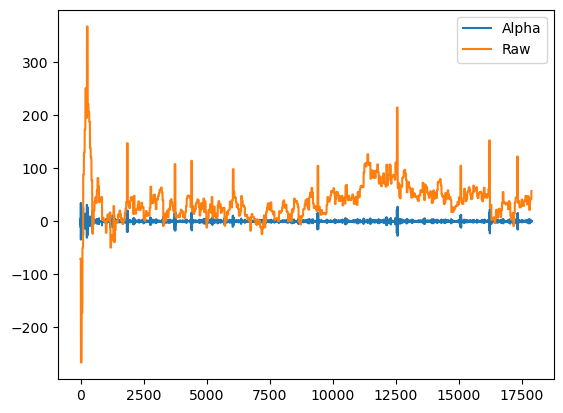

In [101]:
plt.plot(alpha_signal, label='Alpha')
plt.plot(channel, label='Raw')
plt.legend()
plt.show()

# Old Stuff

In [166]:
high_res_time = np.arange(behavior_df['flip_time'].iloc[0], behavior_df['flip_time'].iloc[-1], 0.001)

interp_funcs = {
    col: interp1d(behavior_df['flip_time'], behavior_df[col], kind='linear', fill_value="extrapolate")
    for col in behavior_df.columns if col != 'flip_time'
}

upsampled_behavior = pd.DataFrame({col: f(high_res_time) for col, f in interp_funcs.items()})
upsampled_behavior['flip_time'] = high_res_time

In [190]:
eeg_df['annot'] = np.nan

for j in range(len(annot_df)):
    annot_data = annot_df.iloc[j, 0].split()
    onset = float(annot_data[0])
    duration = float(annot_data[1])
    annot = annot_data[2]
    if duration == 0:
        onset = find_nearest(eeg_df['time'], onset, return_index=True)[1]
        eeg_df.loc[onset, 'annot'] = annot
    else:
        onset = find_nearest(eeg_df['time'], onset, return_index=True)[1]
        offset = find_nearest(eeg_df['time'], onset+duration, return_index=True)[1]
        eeg_df.loc[onset:offset, 'annot'] = annot

onset_ind = list(eeg_df[eeg_df['annot'].fillna('').str.contains('Onset')].index)[0]
offset_ind = list(eeg_df[eeg_df['annot'].fillna('').str.contains('TaskEnded')].index)[0]

eeg_df = eeg_df.loc[onset_ind:offset_ind].reset_index(drop=True)
eeg_df['time'] = eeg_df['time'] - eeg_df['time'][0]

/var/folders/w0/4d261sg51qjdphncfst0x4fr0000gn/T/ipykernel_19518/3542028202.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'BAD_muscle' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  eeg_df.loc[onset:offset, 'annot'] = annot


In [225]:
upsampled_behavior['time'] = upsampled_behavior['flip_time']
eeg_df['time'] = eeg_df['time'].round(3)
upsampled_behavior['time'] = upsampled_behavior['time'].round(3)

behavior_cols = upsampled_behavior.select_dtypes(include=['number']).columns
eeg_cols = eeg_df.select_dtypes(include=['number']).columns
eeg_cols = [col for col in eeg_df.columns if col != 'time' and np.issubdtype(eeg_df[col].dtype, np.number)]

merged_df = pd.merge(upsampled_behavior, eeg_df, on='time')

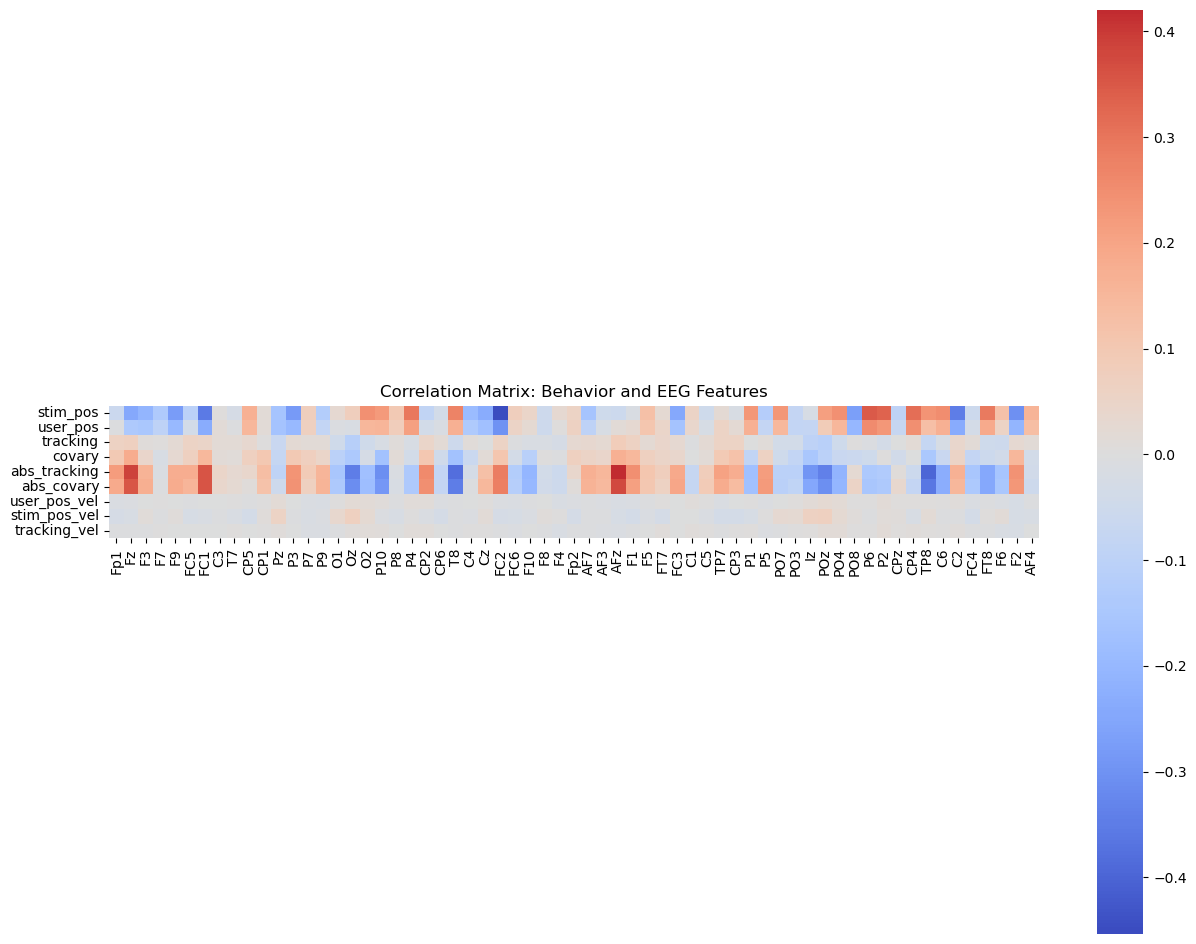

In [226]:
eeg_cols = [col for col in eeg_cols if 'time' not in col]
behavior_cols = [col for col in behavior_cols if 'time' not in col]
cross_corr = pd.DataFrame(index=behavior_cols, columns=eeg_cols)

for b_col in behavior_cols:
    for e_col in eeg_cols:
        cross_corr.loc[b_col, e_col] = merged_df[b_col].corr(merged_df[e_col])

cross_corr = cross_corr.astype(float)

plt.figure(figsize=(15, 12))
sns.heatmap(cross_corr, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix: Behavior and EEG Features')
plt.show()

In [ ]:
def extract_band_power(eeg_df, eeg_cols, fs, band_name, lowcut, highcut):
    power_df = pd.DataFrame()
    power_df['time'] = eeg_df['time']
    for col in eeg_cols:
        signal = eeg_df[col].values
        filtered = bandpass_filter(signal, fs, lowcut, highcut)
        power = np.abs(hilbert(filtered)) ** 2
        power_df[f'{col}_{band_name}_power'] = power
    return power_df

In [234]:
eeg_df

,time,Fp1,Fz,F3,F7,F9,FC5,FC1,C3,T7,...,CP4,TP8,C6,C2,FC4,FT8,F6,F2,AF4,annot
0,0.000,152.734430,270.118378,2.242187,132.199520,64.478011,36.661219,2.484917,87.197485,10.592079,...,-21.739480,-113.976660,-138.443786,-3.680411,34.913568,-183.300184,-223.835997,-106.063681,321.237195,Onset
1,0.004,156.957921,265.069606,-4.117324,127.005111,58.603959,35.010659,-1.301662,90.741335,14.184475,...,-18.438360,-136.501951,-153.444465,-9.748646,26.612221,-194.125916,-229.030407,-111.646458,321.916837,BAD_muscle
2,0.008,147.540020,269.584374,-6.690255,127.247840,51.370623,32.631911,2.145096,85.207104,11.854272,...,-16.108157,-113.005743,-159.415608,-3.874594,23.311101,-198.106678,-237.234661,-113.831023,324.586861,BAD_muscle
3,0.012,150.792594,272.739856,-9.117550,128.946946,42.680909,29.913342,-1.156025,80.546699,3.067467,...,4.038385,-111.646458,-133.783381,7.193868,33.117370,-184.902198,-252.089702,-115.141762,320.217731,BAD_muscle
4,0.016,142.539794,269.924195,-6.544618,118.703764,30.884259,33.505737,0.591627,85.304196,0.348898,...,-3.194952,-117.326326,-138.880699,4.960757,38.214688,-189.950970,-259.128855,-121.549818,311.188197,BAD_muscle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150036,600.144,26.320946,-1.010387,-57.711980,154.724811,-164.318743,18.893426,-8.292270,-26.691160,51.370623,...,-53.682672,83.896365,-46.060968,-6.884439,20.738169,11.611543,10.640625,-11.593390,-71.207736,BAD_muscle
150037,600.148,31.515356,-2.952222,-54.847773,154.967540,-160.871985,18.116692,-9.505917,-29.264092,57.827225,...,-54.847773,85.595471,-43.682219,-8.098086,25.835487,17.388503,15.155393,-7.078623,-59.168357,BAD_muscle
150038,600.152,37.243770,-3.486227,-52.226295,157.589018,-151.890996,21.563449,-12.855583,-29.992280,65.740204,...,-56.595425,86.420751,-42.517118,-13.875046,24.670386,18.165237,17.388503,-8.340816,-60.527641,BAD_muscle
150039,600.156,34.865022,-0.330745,-51.643745,154.093714,-152.861914,20.398348,-10.428289,-32.128299,60.788524,...,-55.430324,84.624553,-43.876403,-13.729409,22.000362,13.019374,14.135929,-11.302114,-58.731444,BAD_muscle


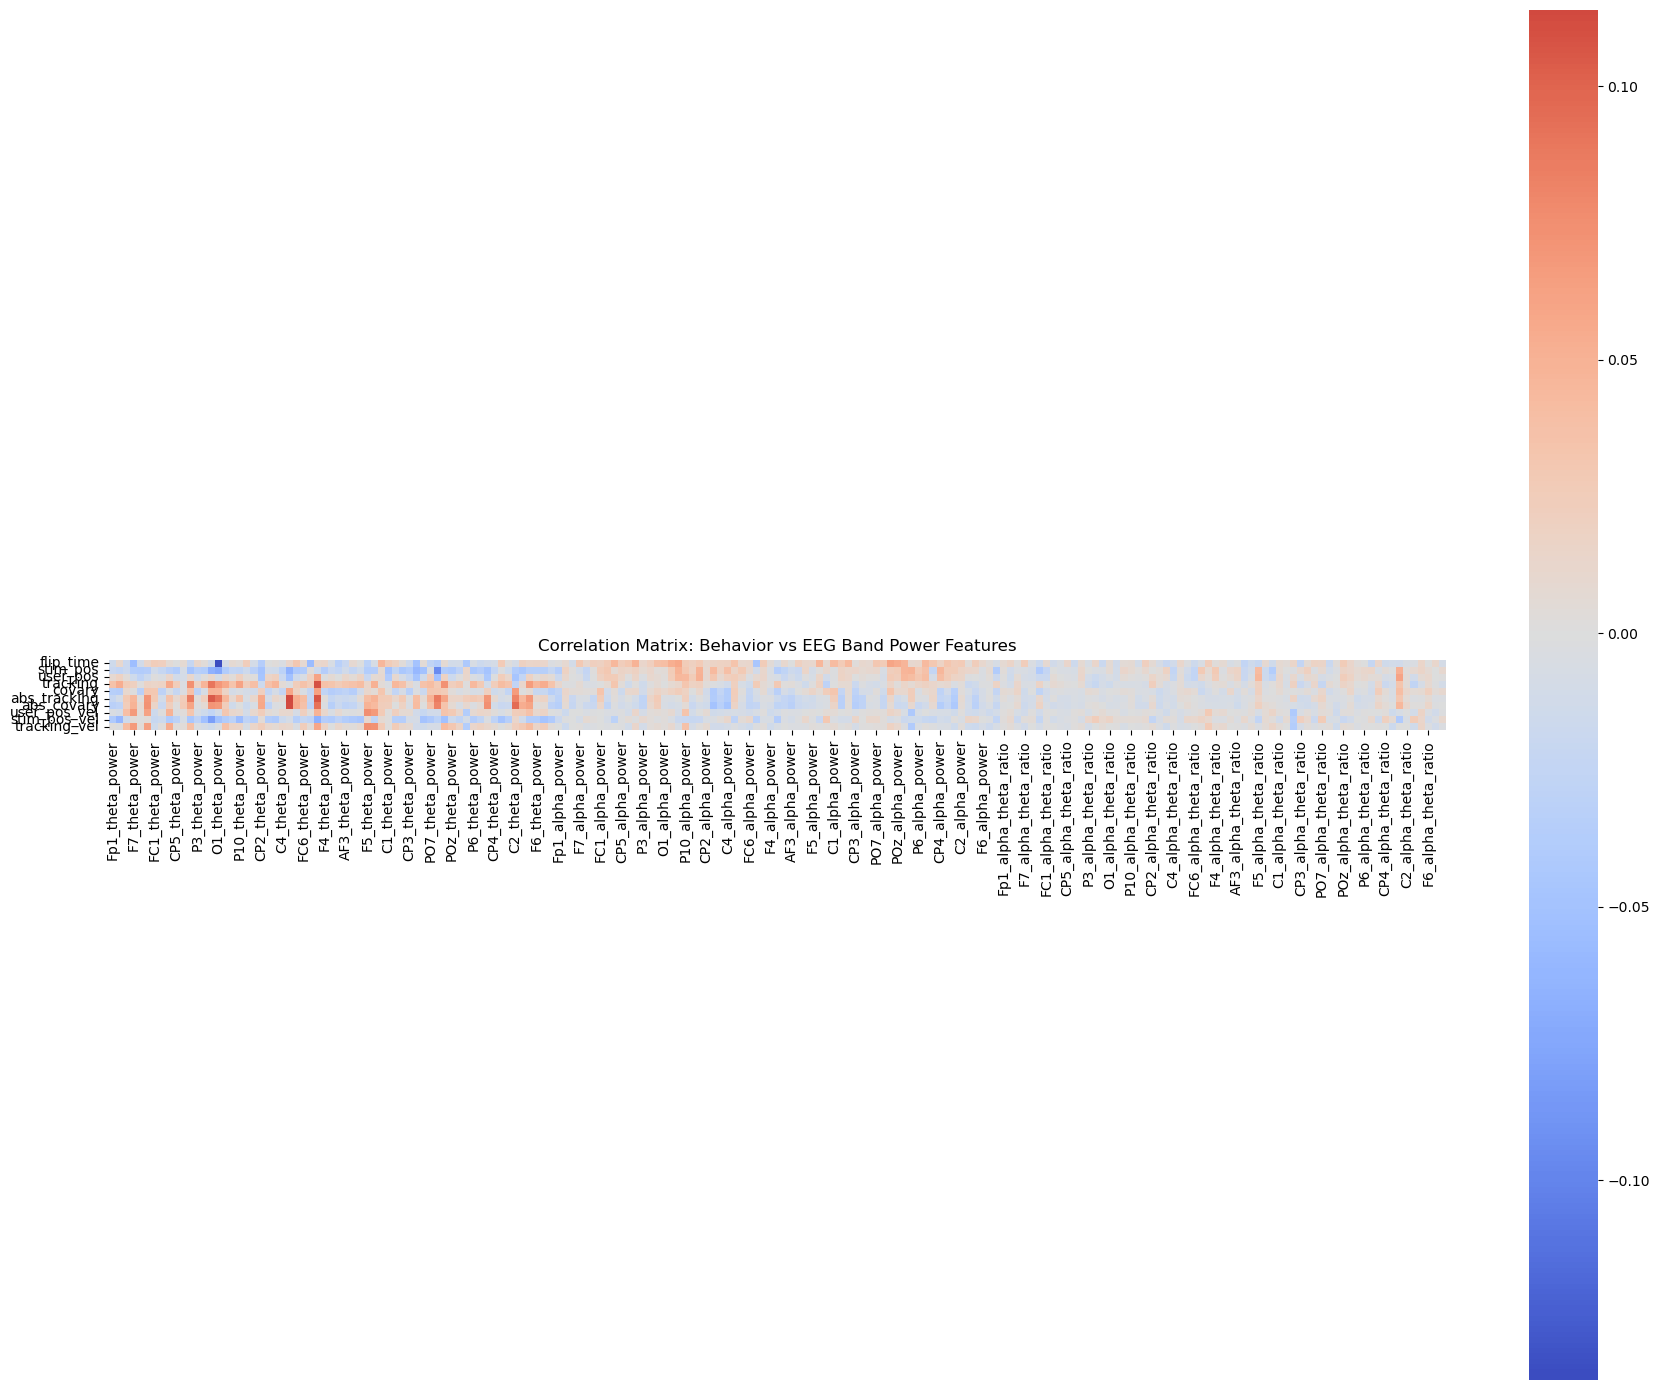

In [232]:
fs = find_nearest(merged_df['time'], np.array(merged_df['time'])[0]+1, return_index=True)[1]
eeg_cols = [col for col in eeg_df.columns if col != 'time' and col != 'annot']

theta_power_df = extract_band_power(eeg_df, eeg_cols, fs, 'theta', 4, 7)
alpha_power_df = extract_band_power(eeg_df, eeg_cols, fs, 'alpha', 8, 12)

alpha_theta_ratio_df = pd.DataFrame()
alpha_theta_ratio_df['time'] = eeg_df['time']
for col in eeg_cols:
    alpha_power = alpha_power_df[f'{col}_alpha_power']
    theta_power = theta_power_df[f'{col}_theta_power']
    ratio = alpha_power / (theta_power + 1e-10)  # prevent division by 0
    alpha_theta_ratio_df[f'{col}_alpha_theta_ratio'] = ratio

power_df = pd.merge(pd.merge(theta_power_df, alpha_power_df, on='time'), alpha_theta_ratio_df, on='time')
merged_df = pd.merge(behavior_df, power_df, on='time')

eeg_power_cols = [col for col in power_df.columns if col != 'time']
behavior_cols = [col for col in behavior_df.columns if col != 'time']

cross_corr = pd.DataFrame(index=behavior_cols, columns=eeg_power_cols)
for b_col in behavior_cols:
    for e_col in eeg_power_cols:
        cross_corr.loc[b_col, e_col] = merged_df[b_col].corr(merged_df[e_col])
cross_corr = cross_corr.astype(float)

plt.figure(figsize=(18, 14))
sns.heatmap(cross_corr, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix: Behavior vs EEG Band Power Features')
plt.tight_layout()
plt.show()

In [ ]:
epoch_start = -0.2  # 200 ms before event
epoch_end = 1.0     # 1 sec after event

epoch_data = []
for event_time in behavior_df['time_secs']:
    mask = (eeg_df['time'] >= event_time + epoch_start) & (eeg_df['time'] <= event_time + epoch_end)
    epoch_data.append(eeg_df[mask].copy())

In [ ]:
raw = mne.io.read_raw_fif('your_file.fif', preload=True)
psd, freqs = mne.time_frequency.psd_welch(raw, fmin=1, fmax=40)

# Optionally group electrodes into regions using your `categorized` dictionary

In [ ]:
import numpy as np
import pandas as pd

# Simulate behavioral data (30 Hz for 10 seconds)
behavior_freq = 30  # Hz
duration_secs = 10
behavior_t = np.arange(0, duration_secs, 1 / behavior_freq)
behavior_df = pd.DataFrame({
    'time_secs': behavior_t,
    'tracking': np.sin(2 * np.pi * 0.5 * behavior_t) + np.random.normal(0, 0.1, len(behavior_t))
})

# Simulate EEG data (1000 Hz for 10 seconds, 64 channels)
eeg_freq = 1000  # Hz
eeg_t = np.arange(0, duration_secs, 1 / eeg_freq)
channels = [f'Ch{i}' for i in range(64)]
eeg_data = {ch: np.sin(2 * np.pi * 10 * eeg_t + np.random.rand() * 2 * np.pi) + np.random.normal(0, 0.5, len(eeg_t)) for ch in channels}
eeg_data['time_secs'] = eeg_t
eeg_df = pd.DataFrame(eeg_data)

# Interpolate behavioral data to match EEG time resolution
from scipy.interpolate import interp1d

interp_funcs = {
    col: interp1d(behavior_df['time_secs'], behavior_df[col], kind='linear', fill_value="extrapolate")
    for col in behavior_df.columns if col != 'time_secs'
}

upsampled_behavior = pd.DataFrame({col: f(eeg_t) for col, f in interp_funcs.items()})
upsampled_behavior['time_secs'] = eeg_t

# Merge EEG and behavior
fused_df = pd.merge(eeg_df, upsampled_behavior, on='time_secs')

# Extract band power using bandpass filters
from scipy.signal import butter, filtfilt

def bandpower(data, low, high, fs):
    b, a = butter(4, [low / (fs / 2), high / (fs / 2)], btype='band')
    filtered = filtfilt(b, a, data)
    return np.mean(filtered ** 2)

# Calculate alpha (8-12 Hz) and theta (4-7 Hz) band power
fs = eeg_freq
alpha_power = fused_df[channels].apply(lambda ch: bandpower(ch, 8, 12, fs))
theta_power = fused_df[channels].apply(lambda ch: bandpower(ch, 4, 7, fs))

# Correlate band power with tracking errors
alpha_corr = alpha_power.corr(fused_df['tracking'])
theta_corr = theta_power.corr(fused_df['tracking'])

alpha_corr, theta_corr

In [ ]:
# Segment length in seconds
window_size = 1
samples_per_window = int(fs * window_size)
n_windows = int(len(fused_df) / samples_per_window)

# Initialize lists
alpha_band_powers = []
theta_band_powers = []
mean_tracking_errors = []

# Process in windows
for i in range(n_windows):
    start = i * samples_per_window
    end = start + samples_per_window
    window = fused_df.iloc[start:end]
    
    alpha_powers = [bandpower(window[ch], 8, 12, fs) for ch in channels]
    theta_powers = [bandpower(window[ch], 4, 7, fs) for ch in channels]
    
    alpha_band_powers.append(np.mean(alpha_powers))
    theta_band_powers.append(np.mean(theta_powers))
    mean_tracking_errors.append(window['tracking'].abs().mean())

# Convert to DataFrame
summary_df = pd.DataFrame({
    'alpha_power': alpha_band_powers,
    'theta_power': theta_band_powers,
    'mean_tracking_error': mean_tracking_errors
})

# Correlation
alpha_corr = summary_df['alpha_power'].corr(summary_df['mean_tracking_error'])
theta_corr = summary_df['theta_power'].corr(summary_df['mean_tracking_error'])

alpha_corr, theta_corr

In [ ]:
from torch.utils.data import Dataset
import torch

class EEGBehaviorDataset(Dataset):
    def __init__(self, eeg, labels):
        self.eeg = torch.tensor(eeg, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.eeg)

    def __getitem__(self, idx):
        return {
            "inputs_embeds": self.eeg[idx],  # [seq_len, embed_dim]
            "labels": self.labels[idx]       # regression target
        }

In [ ]:
from transformers import BertConfig, BertModel
import torch.nn as nn

class EEGTransformerRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=768):
        super().__init__()
        self.transformer = BertModel(BertConfig(
            hidden_size=input_dim,  # match EEG channel count
            num_hidden_layers=4,
            num_attention_heads=4,
            intermediate_size=hidden_dim,
            hidden_act="gelu",
            max_position_embeddings=512
        ))
        self.regressor = nn.Linear(input_dim, 1)

    def forward(self, inputs_embeds=None, labels=None):
        output = self.transformer(inputs_embeds=inputs_embeds).last_hidden_state
        pooled = output.mean(dim=1)
        pred = self.regressor(pooled).squeeze(-1)

        if labels is not None:
            loss = nn.MSELoss()(pred, labels)
            return {"loss": loss, "logits": pred}
        return {"logits": pred}

In [ ]:
from transformers import Trainer, TrainingArguments

train_dataset = EEGBehaviorDataset(eeg_train, labels_train)
val_dataset = EEGBehaviorDataset(eeg_val, labels_val)

model = EEGTransformerRegressor(input_dim=eeg_train.shape[-1])

args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    num_train_epochs=10,
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

In [ ]:
preds = trainer.predict(val_dataset).predictions
correlation = np.corrcoef(preds.squeeze(), labels_val)[0, 1]
print(f"Correlation between predicted and true behavior: {correlation:.3f}")